# Tutorial 4: Surrogate-Based Optimization

Our goal will be to train a neural network to predict the Rosenbrock function, defined as below, and then use the surrogate to find the minimum. 

$
f(x_1, x_2) = (1 - x_1)^2 + 100 (x_2 - x_1^2)^ 2
$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import jenn
from typing import List, Tuple, Union, Callable
from jenn.utils import plot
from jenn.utils import metrics 

### Synthetic Data

In a first step, let's define the test function:

In [2]:
test_function = jenn.synthetic.Rosenbrock

Next, let's define the domain over which we will collect synthetic training data:

In [3]:
lb = (-2.0, -2.0)
ub = (2.0, 2.0)

We will now generate some synthetic data that will be used to train our GENN model later on:

In [ ]:
REFINE = 25  # JENN finds optimum but not NN 
COARSE = 6  # JENN does not find optimum but does much better than NN 

In [4]:
x_train, y_train, dydx_train = test_function.sample(m_lhs=0, m_levels=REFINE, lb=lb, ub=ub)

We also generate some synthetic data that will be used to test the accuracy of the trained model:

In [5]:
x_test, y_test, dydx_test = test_function.sample(m_lhs=100, m_levels=0, lb=lb, ub=ub)

### Training

For comparison, let's train two models: a regular neural network and gradient-enhanced neural network. 

#### Helper Functions

_Since we'll be repeating the same steps for both NN and JENN... write them once for both._

In [6]:
def fit(deep: int, wide: int, lambd: float, alpha: float, gamma: int | float = 0): 
    """Fit neural network given hyperparameters."""
    return jenn.model.NeuralNet(
        layer_sizes=[2] + [wide] * deep + [1],
    ).fit(
        x=x_train, 
        y=y_train, 
        dydx=dydx_train,
        max_iter=10_000, 
        alpha=alpha, 
        lambd=lambd, 
        gamma=gamma, 
        is_normalize=True, 
    )

In [7]:
def tune(deep: list[int], wide: List[int], lambd: List[float], alpha: List[float], gamma: Union[int, float] = 0):
    """Tune hyperparameters by enumeration."""
    best = dict() 
    best_r2 = 0
    for w in wide: 
        for d in deep: 
            for h in lambd: 
                for a in alpha: 
                    model = fit(deep=d, wide=w, lambd=h, alpha=a, gamma=gamma)
                    r2 = 0.5 * (
                        metrics.r_square(
                            y_pred=model.predict_partials(x_test)[0, 0], 
                            y_true=dydx_test[0, 0],
                        ) + metrics.r_square(
                            y_pred=model.predict_partials(x_test)[0, 1], 
                            y_true=dydx_test[0, 1],
                        )
                    )
                    if r2 > best_r2: 
                        best_r2 = r2
                        best["deep"] = d
                        best["wide"] = w
                        best["lambd"] = h
                        best["alpha"] = a
                        best["gamma"] = gamma
    return best 

In [8]:
hyperparameters = dict(deep=[2], wide=[24], lambd=[1e-1, 1e-2, 1e-3], alpha=[0.01])

#### Regular Neural Network

In [9]:
%%time
nn = fit(**tune(**hyperparameters, gamma=0))

CPU times: user 18.4 s, sys: 29.9 ms, total: 18.4 s
Wall time: 18.4 s


#### Gradient-Enhanced Neural Network

In [10]:
%%time
genn = fit(**tune(**hyperparameters, gamma=1))

CPU times: user 19.3 s, sys: 18.2 ms, total: 19.3 s
Wall time: 19.4 s


### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

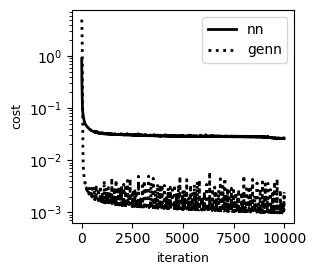

In [11]:
plot.convergence(histories=[nn.history, genn.history], legend=["nn", "genn"])

#### Goodness of Fit

Upon convergence, let's check how well the model generalizes on test data. All else being equal, GENN generally outperforms NN.

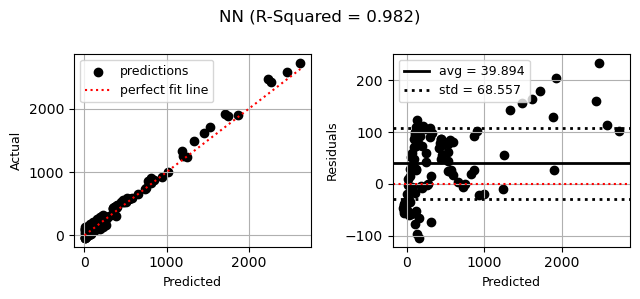

In [12]:
plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=nn.predict(x_test),
    title="NN"
)

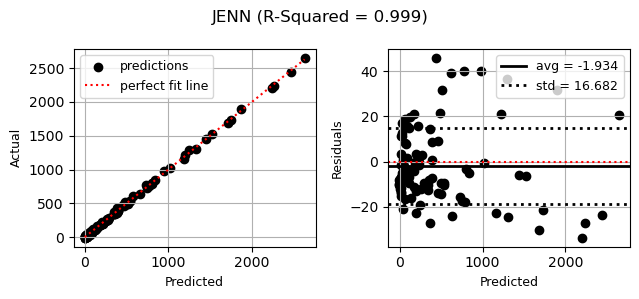

In [13]:
plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=genn.predict(x_test),
    title="JENN"
)

### Optimization

#### Helper Functions

Since this is a two-dimensional function, we can compare the contour plots of the predicted and true response:

In [24]:
@jenn.utils.plot.requires_matplotlib 
def optimize(
        f: Callable,  
        dfdx: Callable,  
        x0: Tuple[float, float] = (1.25, -1.75), 
        alpha: float = .2, 
        max_iter: int = 100_000,
        ax: plt.Axes | None = None, 
        title: str = "", 
        levels: int = 100, 
        is_legend: bool = True, 
    ):
    """Check that optimizer yields correct answer for rosenbrock function."""
    
    # Initial guess
    x0 = np.array(x0).reshape((2, 1))

    # Optimization
    opt = jenn.core.optimization.ADAMOptimizer()
    xf = opt.minimize(x0, f, dfdx, alpha=alpha, max_iter=max_iter)

    # For plotting contours
    lb = -2.
    ub = 2.
    m = 100
    x1 = np.linspace(lb, ub, m)
    x2 = np.linspace(lb, ub, m)
    X1, X2 = np.meshgrid(x1, x2)
    Y = np.zeros(X1.shape)
    for i in range(0, m):
        for j in range(0, m):
            X = np.array([
                [X1[i, j]],
                [X2[i, j]],
            ])
            Y[i, j] = f(X).squeeze()
        
    if ax is not None:
        x1_his = np.array([x[0] for x in opt.vars_history]).squeeze()
        x2_his = np.array([x[1] for x in opt.vars_history]).squeeze()
        ax.plot(x1_his, x2_his)
        ax.plot(x0[0], x0[1], '+', ms=15)
        ax.plot(xf[0], xf[1], 'o')
        ax.plot(np.array([1.]), np.array([1.]), 'x')
        if is_legend: 
            ax.legend(['history', 'initial guess', 'predicted optimum', 'true optimum'])
        ax.contour(X1, X2, Y, levels, cmap='RdGy')
        ax.set_title(title)

In [25]:
@jenn.utils.plot.requires_matplotlib 
def plot_contours(
    x0: Tuple[float, float] = (1.25, -1.75), 
    levels: int = 100,
    **kwargs, 
): 
    """Plot contours of True, JENN and NN side by side."""
    import matplotlib.pyplot as plt 
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    optimize(
        f=test_function.evaluate, 
        dfdx=test_function.first_derivative, 
        x0=x0,
        ax=ax[0],
        title="True", 
        levels=levels,
        **kwargs
    )
    optimize(
        f=genn.predict, 
        dfdx=genn.predict_partials, 
        x0=x0,
        ax=ax[1],
        is_legend=False,
        title="JENN",
        levels=levels,
        **kwargs
    )
    optimize(
        f=nn.predict, 
        dfdx=nn.predict_partials, 
        x0=x0,
        ax=ax[2], 
        is_legend=False, 
        title="NN",
        levels=levels,
        **kwargs
    )
    plt.close(fig)
    return fig

#### Compare Results

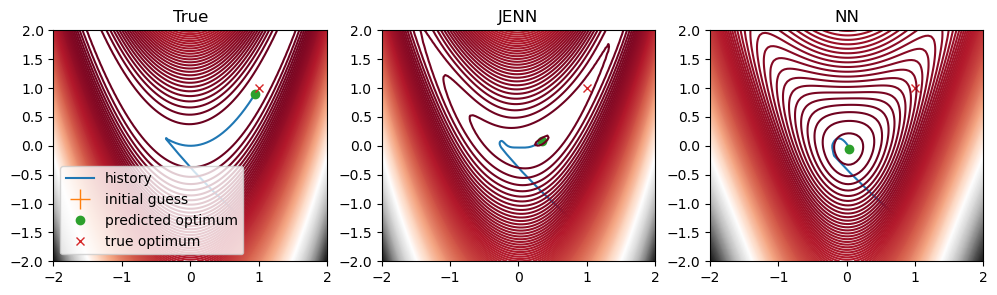

In [27]:
plot_contours(x0=(1.25, -1.75), levels=300, alpha=0.2)